In [1]:
# Imports
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from talib import RSI, BBANDS, MACD, ATR

### OHLCV data

In [2]:
# Loading the data
ohlcv = pd.read_csv('./data/ohlcv.csv')
ohlcv["Date"] = pd.to_datetime(ohlcv['Date'], format='%Y-%m-%d')
ohlcv.columns = list(map(str.lower, ohlcv.columns))
ohlcv.set_index(["ticker", "date"], inplace=True)

In [3]:
# Specifying sample period
ohlcv.sort_index(level=[0,1], ascending=[True, True], inplace=True)
ohlcv = ohlcv.loc[pd.IndexSlice[:, '2014-01-01':'2020-12-31'], :]
ohlcv

open        high         low       close     volume
ticker date                                                                 
A      2014-01-02   38.137327   38.137327   37.502818   37.542892  2678848.0
       2014-01-03   37.663113   38.304297   37.576284   38.017101  2609647.0
       2014-01-06   38.337699   38.538070   37.776661   37.830093  2484665.0
       2014-01-07   38.037126   38.491300   38.023769   38.371078  2045554.0
       2014-01-08   38.290947   39.099114   38.184083   38.998928  3717981.0
...                       ...         ...         ...         ...        ...
ZTS    2020-12-24  159.233582  161.175209  159.163890  160.030151   417400.0
       2020-12-28  160.747074  162.131107  159.621919  161.692993  1522400.0
       2020-12-29  162.509486  164.391373  161.702950  162.419861  1188400.0
       2020-12-30  162.808163  164.092635  162.459675  163.564911  1009000.0
       2020-12-31  163.793950  164.968878  162.529396  164.789658  1292600.0

[870305 rows x 5 columns]

In [4]:
# Creating dollar volume features
ohlcv["dollarvolume"] = ohlcv['close']*ohlcv['volume']
ohlcv['dollarvolume1monthrolling'] = ohlcv.dollarvolume.groupby('ticker').rolling(window=21).mean().values

In [5]:
ohlcv

open        high         low       close     volume  \
ticker date                                                                    
A      2014-01-02   38.137327   38.137327   37.502818   37.542892  2678848.0   
       2014-01-03   37.663113   38.304297   37.576284   38.017101  2609647.0   
       2014-01-06   38.337699   38.538070   37.776661   37.830093  2484665.0   
       2014-01-07   38.037126   38.491300   38.023769   38.371078  2045554.0   
       2014-01-08   38.290947   39.099114   38.184083   38.998928  3717981.0   
...                       ...         ...         ...         ...        ...   
ZTS    2020-12-24  159.233582  161.175209  159.163890  160.030151   417400.0   
       2020-12-28  160.747074  162.131107  159.621919  161.692993  1522400.0   
       2020-12-29  162.509486  164.391373  161.702950  162.419861  1188400.0   
       2020-12-30  162.808163  164.092635  162.459675  163.564911  1009000.0   
       2020-12-31  163.793950  164.968878  162.529396  164.789658  1292600.0   

                   dollarvolume  dollarvolume1monthrolling  
ticker date                                                 
A      2014-01-02  1.005717e+08                        NaN  
       2014-01-03  9.921121e+07                        NaN  
       2014-01-06  9.399511e+07                        NaN  
       2014-01-07  7.849011e+07                        NaN  
       2014-01-08  1.449973e+08                        NaN  
...                         ...                        ...  
ZTS    2020-12-24  6.679659e+07               2.770643e+08  
       2020-12-28  2.461614e+08               2.737338e+08  
       2020-12-29  1.930198e+08               2.763923e+08  
       2020-12-30  1.650370e+08               2.497738e+08  
       2020-12-31  2.130071e+08               2.448877e+08  

[870305 rows x 7 columns]

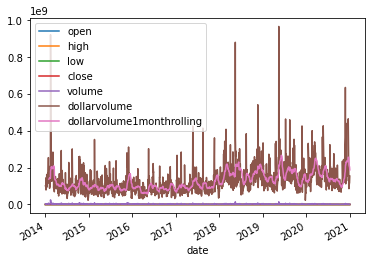

In [6]:
ohlcv.loc["A"].plot()

### Fama-French factor data

In [7]:
# Loading the data
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2014', end='2021')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data.index.name = 'date'
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2014-01-01,-3.32,0.58,-2.02,-3.93,-1.36
2014-02-01,4.65,0.11,-0.36,-0.24,-0.41
2014-03-01,0.43,-1.12,4.90,2.17,1.83
2014-04-01,-0.19,-4.13,1.12,3.53,1.02
2014-05-01,2.06,-1.91,-0.12,0.03,-1.05
...,...,...,...,...,...
2020-09-01,-3.63,0.07,-2.51,-1.15,-1.77
2020-10-01,-2.10,4.76,4.03,-0.60,-0.53
2020-11-01,12.47,6.75,2.11,-2.78,1.05


In [8]:
# Resampling factor data into daily frequency
factor_data = factor_data.resample('D').first()
for x in factor_data.index[:-1]:
    if (x.day==1):
        first=x
    factor_data.loc[x] = factor_data.loc[first]
factor_data.drop(['2021-01-01'], inplace=True)
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2014-01-01,-3.32,0.58,-2.02,-3.93,-1.36
2014-01-02,-3.32,0.58,-2.02,-3.93,-1.36
2014-01-03,-3.32,0.58,-2.02,-3.93,-1.36
2014-01-04,-3.32,0.58,-2.02,-3.93,-1.36
2014-01-05,-3.32,0.58,-2.02,-3.93,-1.36
...,...,...,...,...,...
2020-12-27,4.63,4.67,-1.36,-2.15,0.00
2020-12-28,4.63,4.67,-1.36,-2.15,0.00
2020-12-29,4.63,4.67,-1.36,-2.15,0.00


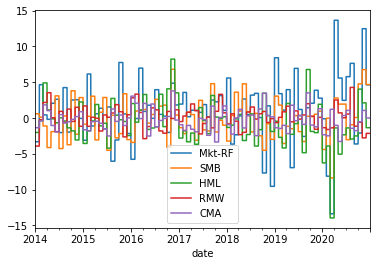

In [9]:
factor_data.plot()

In [10]:
# Merging OHLCV and factor data
factor = pd.merge(ohlcv.reset_index(), factor_data.reset_index(), on='date')
factor.set_index(["ticker", "date"], inplace=True)
factor.sort_index(level=[0,1], ascending=[True, True], inplace=True)
factor

open        high         low       close     volume  \
ticker date                                                                    
A      2014-01-02   38.137327   38.137327   37.502818   37.542892  2678848.0   
       2014-01-03   37.663113   38.304297   37.576284   38.017101  2609647.0   
       2014-01-06   38.337699   38.538070   37.776661   37.830093  2484665.0   
       2014-01-07   38.037126   38.491300   38.023769   38.371078  2045554.0   
       2014-01-08   38.290947   39.099114   38.184083   38.998928  3717981.0   
...                       ...         ...         ...         ...        ...   
ZTS    2020-12-24  159.233582  161.175209  159.163890  160.030151   417400.0   
       2020-12-28  160.747074  162.131107  159.621919  161.692993  1522400.0   
       2020-12-29  162.509486  164.391373  161.702950  162.419861  1188400.0   
       2020-12-30  162.808163  164.092635  162.459675  163.564911  1009000.0   
       2020-12-31  163.793950  164.968878  162.529396  164.789658  1292600.0   

                   dollarvolume  dollarvolume1monthrolling  Mkt-RF   SMB  \
ticker date                                                                
A      2014-01-02  1.005717e+08                        NaN   -3.32  0.58   
       2014-01-03  9.921121e+07                        NaN   -3.32  0.58   
       2014-01-06  9.399511e+07                        NaN   -3.32  0.58   
       2014-01-07  7.849011e+07                        NaN   -3.32  0.58   
       2014-01-08  1.449973e+08                        NaN   -3.32  0.58   
...                         ...                        ...     ...   ...   
ZTS    2020-12-24  6.679659e+07               2.770643e+08    4.63  4.67   
       2020-12-28  2.461614e+08               2.737338e+08    4.63  4.67   
       2020-12-29  1.930198e+08               2.763923e+08    4.63  4.67   
       2020-12-30  1.650370e+08               2.497738e+08    4.63  4.67   
       2020-12-31  2.130071e+08               2.448877e+08    4.63  4.67   

                    HML   RMW   CMA  
ticker date                          
A      2014-01-02 -2.02 -3.93 -1.36  
       2014-01-03 -2.02 -3.93 -1.36  
       2014-01-06 -2.02 -3.93 -1.36  
       2014-01-07 -2.02 -3.93 -1.36  
       2014-01-08 -2.02 -3.93 -1.36  
...                 ...   ...   ...  
ZTS    2020-12-24 -1.36 -2.15  0.00  
       2020-12-28 -1.36 -2.15  0.00  
       2020-12-29 -1.36 -2.15  0.00  
       2020-12-30 -1.36 -2.15  0.00  
       2020-12-31 -1.36 -2.15  0.00  

[870305 rows x 12 columns]

### Categorical features

In [11]:
# Extracting date features
factor['year'] = factor.index.get_level_values(1).year
factor['month'] = factor.index.get_level_values(1).month
factor["weekday"] = factor.index.get_level_values(1).dayofweek

In [12]:
# Loading company information
info = pd.read_csv('./data/info.csv')
info.columns = list(map(str.lower, info.columns))

In [13]:
# Merging company information
factor = pd.merge(factor.reset_index(), info[["ticker", "sector", "marketcap"]].reset_index(drop=True), on='ticker')
factor.set_index(["ticker", "date"], inplace=True)
factor.sort_index(level=[0,1], ascending=[True, True], inplace=True)
factor

open        high         low       close     volume  \
ticker date                                                                    
A      2014-01-02   38.137327   38.137327   37.502818   37.542892  2678848.0   
       2014-01-03   37.663113   38.304297   37.576284   38.017101  2609647.0   
       2014-01-06   38.337699   38.538070   37.776661   37.830093  2484665.0   
       2014-01-07   38.037126   38.491300   38.023769   38.371078  2045554.0   
       2014-01-08   38.290947   39.099114   38.184083   38.998928  3717981.0   
...                       ...         ...         ...         ...        ...   
ZTS    2020-12-24  159.233582  161.175209  159.163890  160.030151   417400.0   
       2020-12-28  160.747074  162.131107  159.621919  161.692993  1522400.0   
       2020-12-29  162.509486  164.391373  161.702950  162.419861  1188400.0   
       2020-12-30  162.808163  164.092635  162.459675  163.564911  1009000.0   
       2020-12-31  163.793950  164.968878  162.529396  164.789658  1292600.0   

                   dollarvolume  dollarvolume1monthrolling  Mkt-RF   SMB  \
ticker date                                                                
A      2014-01-02  1.005717e+08                        NaN   -3.32  0.58   
       2014-01-03  9.921121e+07                        NaN   -3.32  0.58   
       2014-01-06  9.399511e+07                        NaN   -3.32  0.58   
       2014-01-07  7.849011e+07                        NaN   -3.32  0.58   
       2014-01-08  1.449973e+08                        NaN   -3.32  0.58   
...                         ...                        ...     ...   ...   
ZTS    2020-12-24  6.679659e+07               2.770643e+08    4.63  4.67   
       2020-12-28  2.461614e+08               2.737338e+08    4.63  4.67   
       2020-12-29  1.930198e+08               2.763923e+08    4.63  4.67   
       2020-12-30  1.650370e+08               2.497738e+08    4.63  4.67   
       2020-12-31  2.130071e+08               2.448877e+08    4.63  4.67   

                    HML   RMW   CMA  year  month  weekday      sector  \
ticker date                                                             
A      2014-01-02 -2.02 -3.93 -1.36  2014      1        3  Healthcare   
       2014-01-03 -2.02 -3.93 -1.36  2014      1        4  Healthcare   
       2014-01-06 -2.02 -3.93 -1.36  2014      1        0  Healthcare   
       2014-01-07 -2.02 -3.93 -1.36  2014      1        1  Healthcare   
       2014-01-08 -2.02 -3.93 -1.36  2014      1        2  Healthcare   
...                 ...   ...   ...   ...    ...      ...         ...   
ZTS    2020-12-24 -1.36 -2.15  0.00  2020     12        3  Healthcare   
       2020-12-28 -1.36 -2.15  0.00  2020     12        0  Healthcare   
       2020-12-29 -1.36 -2.15  0.00  2020     12        1  Healthcare   
       2020-12-30 -1.36 -2.15  0.00  2020     12        2  Healthcare   
       2020-12-31 -1.36 -2.15  0.00  2020     12        3  Healthcare   

                      marketcap  
ticker date                      
A      2014-01-02  5.333659e+10  
       2014-01-03  5.333659e+10  
       2014-01-06  5.333659e+10  
       2014-01-07  5.333659e+10  
       2014-01-08  5.333659e+10  
...                         ...  
ZTS    2020-12-24  9.775215e+10  
       2020-12-28  9.775215e+10  
       2020-12-29  9.775215e+10  
       2020-12-30  9.775215e+10  
       2020-12-31  9.775215e+10  

[870305 rows x 17 columns]

In [14]:
# Encoding categorical variables
factor = pd.get_dummies(factor, columns=["year", "month", "weekday", "sector"], drop_first=True)

In [15]:
factor.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 870305 entries, ('A', Timestamp('2014-01-02 00:00:00')) to ('ZTS', Timestamp('2020-12-31 00:00:00'))
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   open                           870302 non-null  float64
 1   high                           870302 non-null  float64
 2   low                            870302 non-null  float64
 3   close                          870302 non-null  float64
 4   volume                         870302 non-null  float64
 5   dollarvolume                   870302 non-null  float64
 6   dollarvolume1monthrolling      860162 non-null  float64
 7   Mkt-RF                         870305 non-null  float64
 8   SMB                            870305 non-null  float64
 9   HML                            870305 non-null  float64
 10  RMW                            870305 non-null  float64
 11  CMA               

### Technical Indicators

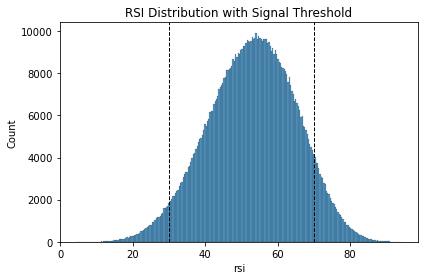

In [16]:
# Adding RSI
factor['rsi'] = factor.groupby(level='ticker').close.apply(RSI)
ax = sns.histplot(factor.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

In [17]:
# Adding Bollinger Bands
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=21)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

factor = factor.join(factor.groupby(level='ticker').close.apply(compute_bb))

### Returns Calculation

In [18]:
# Calculating returns wrt. previous {diff}th day
diffs = [1, 5, 10, 21, 42, 63]
for diff in diffs:
    factor[f'return{diff}day'] = factor.groupby(level='ticker').close.pct_change(diff)

In [19]:
# Comparing returns wrt. previous {t*diff}th day return
for t in [1, 2, 3]:
    for diff in diffs:
        factor[f'return{diff}daylag{t*diff}day'] = factor.groupby(level='ticker')[f'return{diff}day'].shift(t * diff)

### Target returns

In [20]:
# Getting return after {diff} day holding period
for diff in diffs:
    factor[f'target{diff}day'] = factor.groupby(level='ticker')[f'return{diff}day'].shift(-diff)

In [22]:
# Saving the final dataset
factor.to_csv('./data/featureset.csv')

In [23]:
factor.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 870305 entries, ('A', Timestamp('2014-01-02 00:00:00')) to ('ZTS', Timestamp('2020-12-31 00:00:00'))
Data columns (total 77 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   open                           870302 non-null  float64
 1   high                           870302 non-null  float64
 2   low                            870302 non-null  float64
 3   close                          870302 non-null  float64
 4   volume                         870302 non-null  float64
 5   dollarvolume                   870302 non-null  float64
 6   dollarvolume1monthrolling      860162 non-null  float64
 7   Mkt-RF                         870305 non-null  float64
 8   SMB                            870305 non-null  float64
 9   HML                            870305 non-null  float64
 10  RMW                            870305 non-null  float64
 11  CMA               